In [1]:
!pwd

/content


### **Cloning the Github Repository for Global Earthquake Dataset (Stanford Geo Sci 240)**

In [2]:
!git clone https://github.com/sdyinzhen/GS240_resources.git

Cloning into 'GS240_resources'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 64 (delta 21), reused 47 (delta 10), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [3]:
!ls

GS240_resources  sample_data


In [4]:
cd GS240_resources/

/content/GS240_resources


In [5]:
cd EVS_Earthquakes/

/content/GS240_resources/EVS_Earthquakes


In [6]:
!ls

asia_earthquakes.csv		      Load_view_Dataset.ipynb
global_database.csv		      Load_view_Dataset.pdf
InterarrivalTimes_larger_than_M6.csv  north_america_earthquakes.csv
InterarrivalTimes_larger_than_M7.csv


### **Overview of Earthquake dataset (1965- 2016)**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

Assigning respective datasets:

In [29]:
inter_time6 = pd.read_csv('InterarrivalTimes_larger_than_M6.csv')['Interarrival times (>M6)'].str.replace("days","").astype(int)
inter_time7 = pd.read_csv('InterarrivalTimes_larger_than_M7.csv')['Interarrival times (>M7)'].str.replace("days","").astype(int)
earthq_file =  pd.read_csv('global_database.csv')
earthq_data =  pd.read_csv('global_database.csv')['Magnitude']


In [ ]:
pip install geopandas

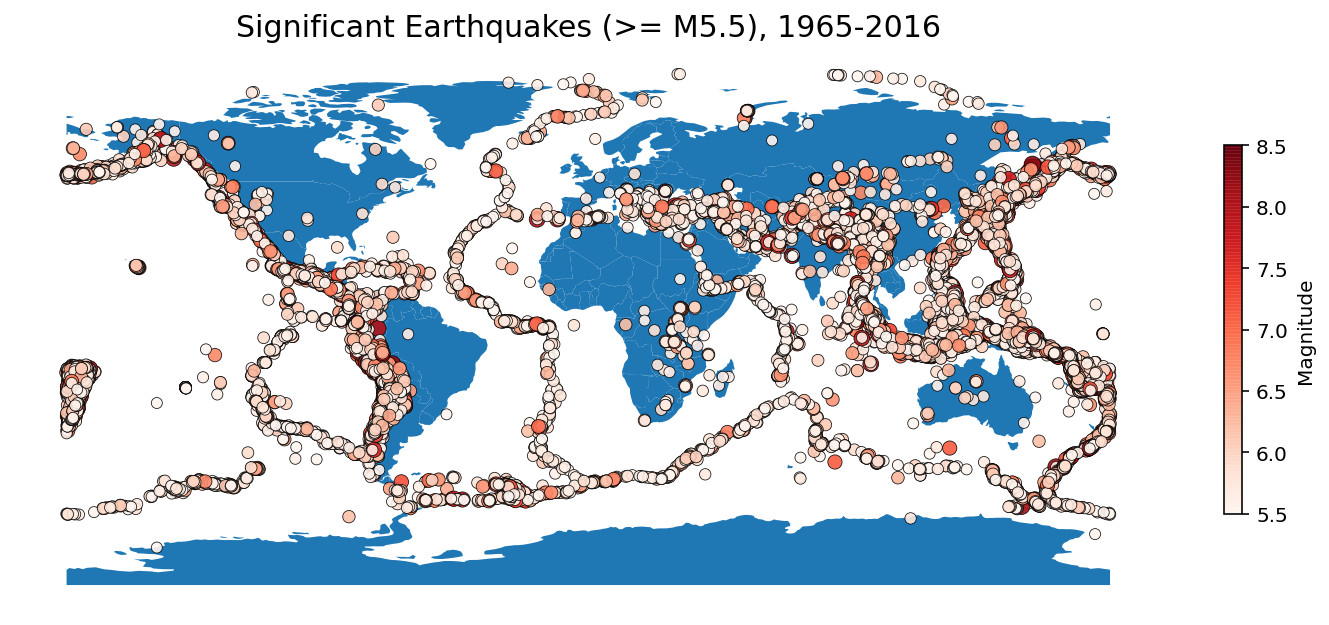

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import datetime

geometry = [Point(xy) for xy in zip(earthq_file['Longitude'], earthq_file['Latitude'])]
gdf = GeoDataFrame(earthq_file[['Longitude', 'Latitude']], geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=, marker='o', color='red', markersize=15);

world.plot(figsize=(11, 6))
plt.scatter(earthq_file['Longitude'], earthq_file['Latitude'], marker='o', 
         c=earthq_file['Magnitude'],cmap='Reds', vmin = 5.5, vmax= 8.5, alpha=0.9,
         s=earthq_file['Magnitude']**2, linewidths=0.4, edgecolors='k')


plt.colorbar(label='Magnitude',fraction=0.015)

plt.title('Significant Earthquakes (>= M5.5), 1965-2016', fontsize = 15)
plt.axis('off')
plt.show()

Text(0, 0.5, 'Interarrival time (days)')

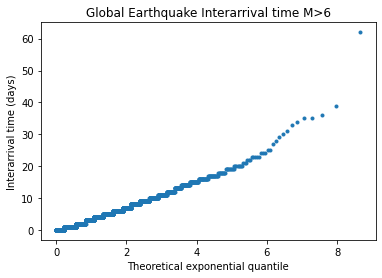

In [10]:
def exponential_quantile(data):
    data = np.sort(data)[::-1]
    n = len(data)
    P_X_larger_x = np.arange(1,n+1)/(n+1)
    fig = plt.figure()
    plt.plot(-np.log(P_X_larger_x),data,'.')
    plt.xlabel('Theoretical exponential quantile')
    


exponential_quantile(inter_time6)
plt.title('Global Earthquake Interarrival time M>6')
plt.ylabel('Interarrival time (days)')

Text(0, 0.5, 'Interarrival time (days)')

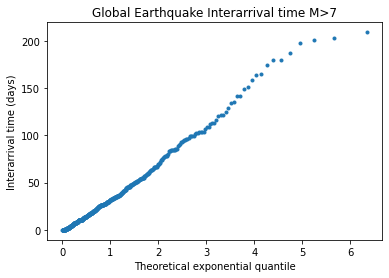

In [11]:
exponential_quantile(inter_time7)
plt.title('Global Earthquake Interarrival time M>7')
plt.ylabel('Interarrival time (days)')

- The linearity between exponential quantiles and interarrival days of large discrete earthquakes (M> 6 and M>7 richter scales) shows that the arrival of large earthquakes follow exponential distribution. Exponential distribution is often called the 'memoryless distribution' because the events are random and not correlated. This statistically proves that large discrete earthquakes are truely random and not influenced by arrival of the other.

### **Creating a Return Period plot of the Earthquakes to extrapolate for 1000 year event estimation**

In [12]:
## calculate empirical return period
empirical_M = np.unique(np.sort(earthq_data))
empirical_return_period = np.zeros(len(empirical_M))
for i, vei in enumerate(empirical_M):
    empirical_return_period[i] = (2016-1965)/np.sum(earthq_data>=vei)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


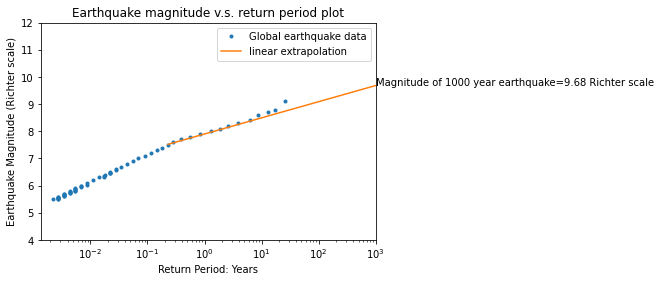

In [13]:
## Empirical return period v.s. return level plot
plt.plot(empirical_return_period,empirical_M,'.', label='Global earthquake data')
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Earthquake Magnitude (Richter scale)')
plt.title('Earthquake magnitude v.s. return period plot')
plt.xlim([0, 1000])
plt.ylim([4, 12])

#manually extrapolationg the data for 1000 year event
x_out=np.linspace(0.22869955,1000,100)
y_out= [np.log10(i)*0.59468+7.9 for i in x_out]
plt.plot(x_out,y_out, label='linear extrapolation')
plt.text(1000,round(max(y_out),2),'Magnitude of 1000 year earthquake='+str(round(max(y_out),2))+' Richter scale',horizontalalignment='left')
plt.legend()

- As can be seen from the linear extrapolation in part c), the 1000 year earthquake event has the magnitude approximately **9.7 Richter scale.**

- As can be seen from the linear extrapolation in part c), the earthquake of 9.5 Richter scale magnitude has a return period around **500 years.**

### **Fitting General Pareto Distribution to estimate the maximum Statistical limit of an earthquake magnitude globally** 

Here, for our sample size of the earthquake dataset (~24000), we will use Peaks Over Threshold method to fit General Pareto Distribution (GPD):

1.   Select a threshold $u$
2.   Extract the exceedances from the dataset, find all data larger than $u$
3.   Fit Generalized Pareto Distribution to the exceedances:
     Exceedances of the dataset is a Generalized Pareto Distribution. 
     $$GPD(y) = P(X\leq u+y|X>u) = 1- P(X>u+y|X>u)$$
4.   Then for any return value $x$, if we denote $x = u+y$:
$$P(X>x) = P(X>u+y)  = P(X>u+y|X>u)P(X>u) = (1-GPD(y))P(X>u)$$
$P(X>u)$ can be estimated empirically. 
Then the return period $T(x)$ is:
$$T(x) = \frac{1}{P(X>x)} = \frac{1}{(1-GPD(x-u))P(X>u)}$$
where $x>u$.

The simplest GPD is when $\xi= 0$, which is an exponential distribution: 
$$GPD(x) = 1-\exp\left(-\frac{(x-\mu)}{\sigma}\right)$$

In this simple case: 
$$P(X>x) = (1-GPD(y))P(X>u) = P(X>u)\exp\left(-\frac{(x-u-\mu)}{\sigma}\right)$$
Therefore, if we replace $P(X>x)$ with $T(x)$ and take a logarithm: 
$$x = \sigma\log(T(x)P(x>u))+\mu+u $$

where we have a linear relationship between return level $X$ and logarithm of the return period $T(x)$

In [14]:
 
u=6.3 #GPD seems to fit the best at u= 6.3M (trial & error)
from scipy.stats import genpareto
xi, mu, sigma =genpareto.fit(earthq_data[earthq_data>u]-u)
print('xi: '+str(xi))

xi: -0.15386720793813002


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


- As can be seen from the fitting in Part g), the estimated value of extreme value index:$$\xi= -0.154$$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


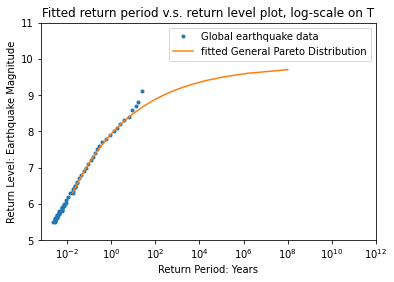

In [15]:
def return_period_function(return_level_x, u, xi, mu, sigma, data, time_interval =51):
    ## 1−𝐺𝑃𝐷(𝑦),y = x - u
    one_minus_GPD_y = 1-genpareto.cdf(return_level_x-u,xi,mu,sigma)

    ## Pu = 𝑃(𝑋>𝑢)
    Pu = np.sum(data>u)/time_interval

    ## P(X>x)
    exceedance_prob = one_minus_GPD_y*Pu

    ## T = 1/P(X>x)
    return_period_T = 1/exceedance_prob

    return return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob

return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob= return_period_function(np.arange(6.3,10,0.1), u, xi, mu, sigma, earthq_data, time_interval = 51)

## Fitted return period v.s. return level plot, log-scale on T
plt.plot(empirical_return_period,empirical_M,'.',label='Global earthquake data')
plt.plot(return_period_T,return_level_x, label='fitted General Pareto Distribution')
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Return Level: Earthquake Magnitude')
plt.xlim([0, 10**12])
plt.ylim([5, 11])
plt.title('Fitted return period v.s. return level plot, log-scale on T')
plt.legend()

Text(9.8, 0.0, 'Max statistically possible magnitude=9.8 Richter scale')

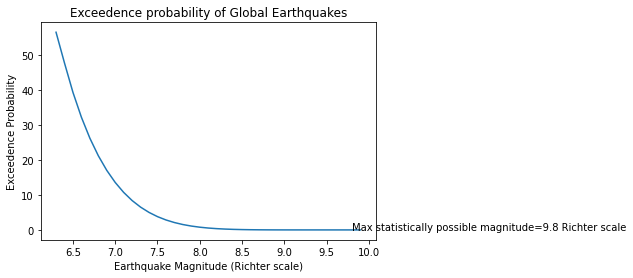

In [16]:
plt.figure()
plt.plot(return_level_x,exceedance_prob)
plt.ylabel('Exceedence Probability')
plt.xlabel('Earthquake Magnitude (Richter scale)')
plt.title('Exceedence probability of Global Earthquakes')
max_earthquake_global= return_level_x[np.where(exceedance_prob == 0)[0][0]] #Finding where exceedence probability is 0
plt.text(round(max_earthquake_global,2),min(exceedance_prob),'Max statistically possible magnitude='+str(round(max_earthquake_global,2))+' Richter scale',horizontalalignment='left')

- As can be seen from the calculations above, the largest possible (Statistical maximum) Earthquake on a global scale is **9.8 Richter Scale.**

# **Comparing the Earthquake datasets from North America and Asia**

**Q-Q plot between the Earthquake Magnitudes in North America Vs. Asia:**

In [17]:
earthq_data_asia =  pd.read_csv('asia_earthquakes.csv')['Magnitude']
earthq_data_na =  pd.read_csv('north_america_earthquakes.csv')['Magnitude']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Quantile-Quantile plot')

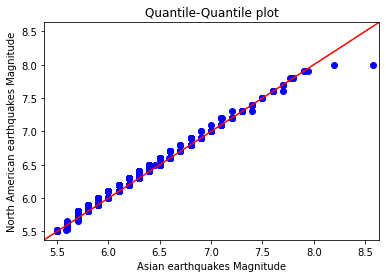

In [18]:
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(earthq_data_na,earthq_data_asia,line='45')
plt.xlabel('Asian earthquakes Magnitude')
plt.ylabel('North American earthquakes Magnitude')
plt.title('Quantile-Quantile plot')

- The Earthquake magnitudes from Asia and North America seem to have similar distribution of quantiles up until when magnitude= 7.8 M. Any Asian Earthquake quantiles past 7.8 M seems to be higher compared to Earthquakes from North America. This indicates that Asia has a higher occurence of large magnitude earthquakes.

**Mean Excess Quantile Comparison between Asia and North America datasets:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


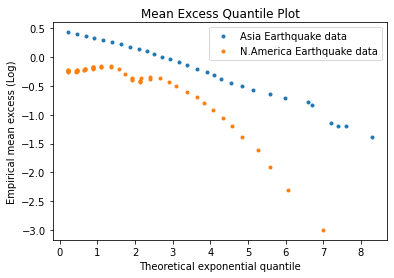

In [19]:
## Mean excess
def meam_excess_d(data):
    data = np.sort(data)
    mean_excess = np.zeros(len(data))
    for k in np.arange(1,len(data)+1):
        mean_excess[k-1] = np.mean(np.unique(data[-k:])-data[-k])
    return mean_excess

## Mean excess quantile plot
n_asia = len(earthq_data_asia)
n_na = len(earthq_data_na)
mean_excess_asia = meam_excess_d(earthq_data_asia)
mean_excess_na = meam_excess_d(earthq_data_na)
uniq_asia, loc_asia, freq_asia = np.unique(mean_excess_asia, return_index= True, return_counts= True)
uniq_na, loc_na, freq_na = np.unique(mean_excess_na, return_index= True, return_counts= True)
log_theoretical_quantile_asia = -np.log(loc_asia/(n_asia+1))
log_mean_excess_asia = np.log(mean_excess_asia[np.array(loc_asia)])
log_theoretical_quantile_na = -np.log(loc_na/(n_na+1))
log_mean_excess_na = np.log(mean_excess_na[np.array(loc_na)])

plt.plot(log_theoretical_quantile_asia, log_mean_excess_asia, '.', label='Asia Earthquake data')
plt.plot(log_theoretical_quantile_na, log_mean_excess_na, '.', label='N.America Earthquake data')
plt.xlabel('Theoretical exponential quantile')
plt.ylabel('Empirical mean excess (Log)')
plt.title('Mean Excess Quantile Plot')
plt.legend()

- As we can see, both datasets show negative slopes in Mean Excess Quantile plots, indicating the extreme value index $\xi$ is negative for both distributions. 

**Maximum Statistically Possible Earthquake Magnitude in Asia:**

In [20]:
## calculate empirical return period
empirical_M = np.unique(np.sort(earthq_data_asia))
empirical_return_period = np.zeros(len(empirical_M))
for i, vei in enumerate(empirical_M):
    empirical_return_period[i] = (2016-1965)/np.sum(earthq_data_asia>=vei)

In [21]:
u=8
from scipy.stats import genpareto
xi, mu, sigma =genpareto.fit(earthq_data_asia[earthq_data_asia>u]-u)
print('xi: '+str(xi))

xi: -1.3659099663987284


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


- As can be seen from the General Pareto Distribution fit, the estimated value of extreme value index:$$\xi_{Asia}= -1.366$$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


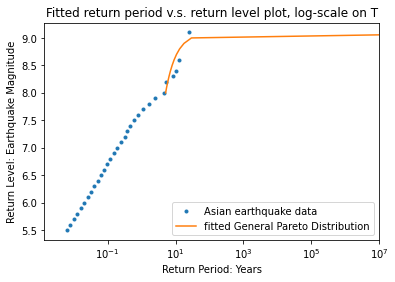

In [22]:
def return_period_function(return_level_x, u, xi, mu, sigma, data, time_interval =51):
    ## 1−𝐺𝑃𝐷(𝑦),y = x - u
    one_minus_GPD_y = 1-genpareto.cdf(return_level_x-u,xi,mu,sigma)

    ## Pu = 𝑃(𝑋>𝑢)
    Pu = np.sum(data>u)/time_interval

    ## P(X>x)
    exceedance_prob = one_minus_GPD_y*Pu

    ## T = 1/P(X>x)
    return_period_T = 1/exceedance_prob

    return return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob

return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob= return_period_function(np.arange(8,12,0.1), u, xi, mu, sigma, earthq_data_asia, time_interval = 51)

## Fitted return period v.s. return level plot, log-scale on T
plt.plot(empirical_return_period,empirical_M,'.',label='Asian earthquake data')
plt.plot(return_period_T,return_level_x, label='fitted General Pareto Distribution')
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Return Level: Earthquake Magnitude')
plt.xlim([0, 10**7])
plt.title('Fitted return period v.s. return level plot, log-scale on T')
plt.legend()

Text(9.1, 0.0, 'Max statistically possible magnitude=9.1 Richter scale')

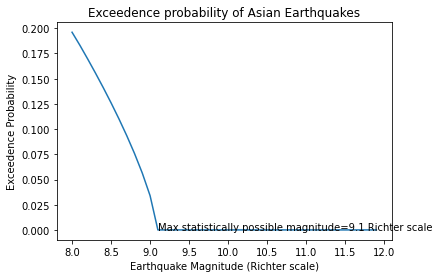

In [23]:
plt.figure()
plt.plot(return_level_x,exceedance_prob)
plt.ylabel('Exceedence Probability')
plt.xlabel('Earthquake Magnitude (Richter scale)')
plt.title('Exceedence probability of Asian Earthquakes')
max_earthquake_global= return_level_x[np.where(np.round(exceedance_prob,6) == 0)[0][0]]
plt.text(round(max_earthquake_global,2),min(exceedance_prob),'Max statistically possible magnitude='+str(round(max_earthquake_global,2))+' Richter scale',horizontalalignment='left')

- As can be seen from the calculations above, the largest possible (Statistical maximum) Earthquake on a global scale is **9.1 Richter Scale.**

**Maximum Statistically Possible Earthquake Magnitude in North America:**

In [24]:
## calculate empirical return period
empirical_M = np.unique(np.sort(earthq_data_na))
empirical_return_period = np.zeros(len(empirical_M))
for i, vei in enumerate(empirical_M):
    empirical_return_period[i] = (2016-1965)/np.sum(earthq_data_na>=vei)

In [25]:
u=7.2
from scipy.stats import genpareto
xi, mu, sigma =genpareto.fit(earthq_data_na[earthq_data_na>u]-u)
print('xi: '+str(xi))

xi: -0.4744946448410442


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


- As can be seen from the General Pareto Distribution fit, the estimated value of extreme value index:$$\xi_{N.America}= -0.474$$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


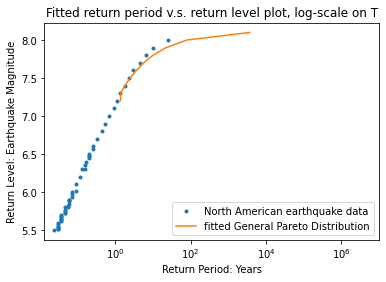

In [26]:
def return_period_function(return_level_x, u, xi, mu, sigma, data, time_interval =51):
    ## 1−𝐺𝑃𝐷(𝑦),y = x - u
    one_minus_GPD_y = 1-genpareto.cdf(return_level_x-u,xi,mu,sigma)

    ## Pu = 𝑃(𝑋>𝑢)
    Pu = np.sum(data>u)/time_interval

    ## P(X>x)
    exceedance_prob = one_minus_GPD_y*Pu

    ## T = 1/P(X>x)
    return_period_T = 1/exceedance_prob

    return return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob

return_level_x, return_period_T, one_minus_GPD_y, exceedance_prob= return_period_function(np.arange(7.2,11,0.1), u, xi, mu, sigma, earthq_data_na, time_interval = 51)

## Fitted return period v.s. return level plot, log-scale on T
plt.plot(empirical_return_period,empirical_M,'.',label='North American earthquake data')
plt.plot(return_period_T,return_level_x, label='fitted General Pareto Distribution')
plt.xscale('log',basex = 10)
plt.xlabel('Return Period: Years')
plt.ylabel('Return Level: Earthquake Magnitude')
plt.xlim([0, 10**7])
plt.title('Fitted return period v.s. return level plot, log-scale on T')
plt.legend()

Text(8.2, 0.0, 'Max statistically possible magnitude=8.2 Richter scale')

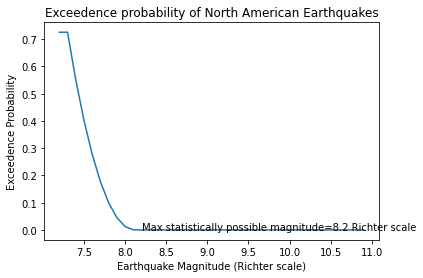

In [27]:
plt.figure()
plt.plot(return_level_x,exceedance_prob)
plt.ylabel('Exceedence Probability')
plt.xlabel('Earthquake Magnitude (Richter scale)')
plt.title('Exceedence probability of North American Earthquakes')
max_earthquake_global= return_level_x[np.where(np.round(exceedance_prob,10) == 0)[0][0]]
plt.text(round(max_earthquake_global,2),min(exceedance_prob),'Max statistically possible magnitude='+str(round(max_earthquake_global,2))+' Richter scale',horizontalalignment='left')

- As can be seen from the calculations above, the largest possible (Statistical maximum) Earthquake on a global scale is **8.2 Richter Scale**, which is lower than that of Asian Earthquake dataset.


# **In Summary:**

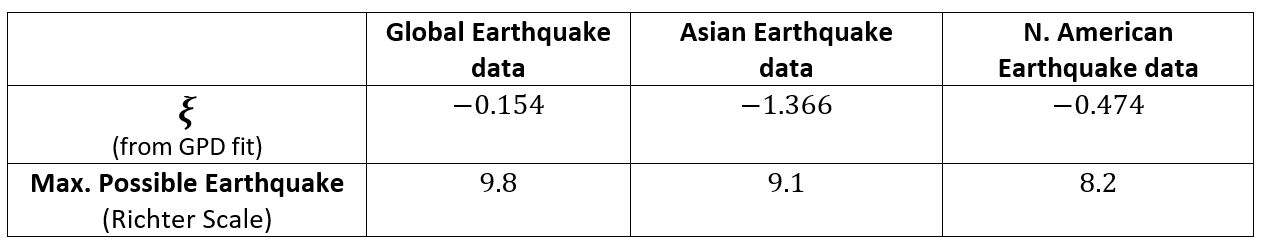